In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score,classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm

In [2]:
from NeuralNetwork.dense import Dense
from NeuralNetwork.activations import Sigmoid,Softmax,ReLU
from NeuralNetwork.losses import categorical_crossentropy, categorical_crossentropy_derive
from NeuralNetwork.network import predict

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
X = mnist.data/255.0
labels = np.array( mnist.target).astype(int)
y = np.squeeze(np.eye(10)[labels])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
X_val, y_val = X_train.iloc[:2000],y_train[:2000]

In [5]:
def train(NN, loss, loss_derive, X_train, y_train,X_val,y_val,epoch=20, alpha=0.05, verbose = True):
    X_train = np.reshape(X_train,X_train.shape +(1,))
    y_train = np.reshape(y_train,y_train.shape +(1,))
    X_val = np.reshape(X_val,X_val.shape +(1,))
    y_val = np.reshape(y_val,y_val.shape +(1,))
    error_TS = []
    acc_TS = []
    val_error_TS = []
    val_acc_TS = []
    for e in range(epoch):
        errors= 0
        acc =0
        val_error = 0
        val_acc = 0
        for x, y in zip(X_train, y_train):
            # forward
            out = predict(NN, x)
            if np.argmax(y)==np.argmax(out):
                acc+=1
            # error

            errors+= loss(y, out)

            # backward
            gradient = loss_derive(y, out)
            for layer in reversed(NN):
                gradient = layer.backward(gradient, alpha)

        for x, y in zip(X_val, y_val):
            output = predict(NN, x)
            if np.argmax(y)==np.argmax(output):
                val_acc+=1
            val_error += loss(y, output)
        
        errors/= len(X_train)
        acc /=len(X_train)
        val_error /= len(X_val)
        val_acc /=len(X_val)

        if verbose:
            print(f"{e + 1}/{epoch}, error={round(errors,4)}, accuracy={round(acc,4)}, val_error={round(val_error,4)}, val_accuracy={round(val_acc,4)}")
        error_TS.append(errors)
        acc_TS.append(acc)
        val_error_TS.append(val_error)
        val_acc_TS.append(val_acc)
    return [error_TS,acc_TS,val_error_TS,val_acc_TS]

In [6]:
def graph_train(train_error,train_acc,val_error,val_acc,index=False):
    add_index = ""
    if index:
        add_index+=index
    plt.plot(train_error)
    plt.plot(val_error)
    plt.xlabel("Epochs")
    plt.ylabel("Error")        
    plt.legend(['train error','validation error'])
    plt.savefig("./graph/Error{}.png".format(add_index))
    plt.clf()
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train accuracy','validation accuracy'])

    plt.savefig("./graph/Accuracy{}.png".format(add_index))

In [7]:
NN = [Dense(784,40),
      Sigmoid(),
      Dense(40,10),
      Softmax()]

In [9]:
train_error,train_acc,val_error,val_acc = train(NN,categorical_crossentropy,categorical_crossentropy_derive,X_train,y_train,X_val,y_val,alpha=0.06,epoch=20)

1/20, error=0.0445, accuracy=0.8647, val_error=0.0314, val_accuracy=0.9055
2/20, error=0.025, accuracy=0.925, val_error=0.0247, val_accuracy=0.9275
3/20, error=0.0201, accuracy=0.9398, val_error=0.0205, val_accuracy=0.9335
4/20, error=0.0174, accuracy=0.9471, val_error=0.0176, val_accuracy=0.9445
5/20, error=0.0156, accuracy=0.9529, val_error=0.0161, val_accuracy=0.9505
6/20, error=0.0139, accuracy=0.9587, val_error=0.0148, val_accuracy=0.952
7/20, error=0.0127, accuracy=0.9623, val_error=0.0124, val_accuracy=0.959
8/20, error=0.0116, accuracy=0.9658, val_error=0.0127, val_accuracy=0.959
9/20, error=0.011, accuracy=0.9676, val_error=0.0138, val_accuracy=0.959
10/20, error=0.0102, accuracy=0.9697, val_error=0.0129, val_accuracy=0.959
11/20, error=0.0096, accuracy=0.9717, val_error=0.0135, val_accuracy=0.956
12/20, error=0.0089, accuracy=0.9737, val_error=0.0122, val_accuracy=0.9595
13/20, error=0.0084, accuracy=0.975, val_error=0.0119, val_accuracy=0.958
14/20, error=0.0079, accuracy=0.

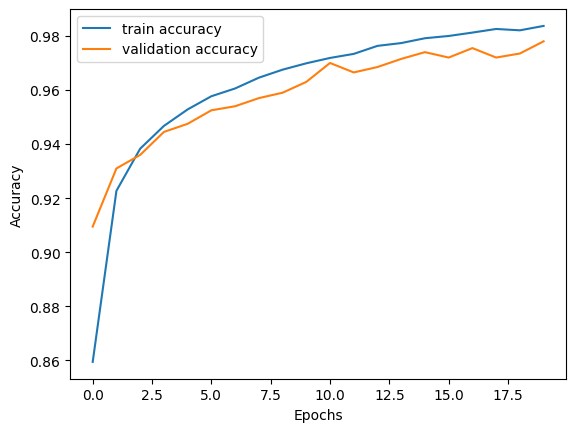

In [9]:
graph_train(train_error,train_acc,val_error,val_acc,index="FINAL")

In [81]:
acc =0
loss = 0
for x,y in zip(X_test.to_numpy().reshape(X_test.shape+(1,)),y_test):
    out = predict(NN,x)
    if out.argmax()==y.argmax():
        acc+=1
    loss+=categorical_crossentropy(y.argmax(),out.argmax())
print("test accuracy:",acc/len(X_test))

test accuracy: 0.9743571428571428


In [10]:
#make pairs
k=100

In [11]:
from sklearn.utils import shuffle
def get_top(X,labels,k=100):
    #dataset = np.column_stack((X,labels))
    X_sample, labels_sample = shuffle(X, labels, )

    topk = []
    for _class in range(10):
        class_index = np.where(labels_sample==_class)[0][:k]
        topk.append(np.column_stack((X_sample.iloc[class_index],labels_sample[class_index])))
    topk = np.vstack(topk)
    return topk

In [12]:
top100 = get_top(X,labels)
np.random.shuffle(top100)

In [14]:
pairs = []
pair_labels = []
for row1 in top100:
    for row2 in top100:
        pairs.append(np.hstack((row2[:-1],row1[:-1])))
        if row1[-1]==row2[-1]:
            pair_labels.append(1)
        else:
            pair_labels.append(0)

pairs = np.vstack(pairs)
pair_labels = np.array(pair_labels)

In [15]:
X_train,X_val,y_train,y_val = train_test_split(pairs,pair_labels,test_size=0.2,shuffle=True)

In [16]:
def predict_siamese(NN,X,threshold=0.5):
    X_sample = X.reshape(len(X), 2, 784)
    predictions = []
    first_images = []
    second_images = []
    
    for sample in X_sample:
        first_images.append(predict(NN,sample[0].reshape(784,1)))
        second_images.append(predict(NN,sample[1].reshape(784,1)))

    for first,second in zip(first_images,second_images):
        euclidean_dist =np.sqrt(np.sum(np.square(first - second)))
        if euclidean_dist<threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [18]:
def eval(predictions,true_val):
    acc = 0
    for pred,true in zip(predictions,true_val):
        if pred==true:
            acc+=1
    return acc/len(true_val)

In [19]:
topk = get_top(X,labels,k=10)
np.random.shuffle(topk)

In [110]:
def eval_siamese(X_sample,label_sample,k=5,threshold = 1.0):
    topk = get_top(X,labels,k)
    np.random.shuffle(topk)
    predictions = []
    for sample,label in zip(X_sample.to_numpy(),label_sample):
        pairs = []
        pair_labels = []
        for row in topk:
            pairs.append(np.hstack((sample[:],row[:-1])))
            pair_labels.append(row[-1])
        pairs = np.vstack(pairs)
        pair_labels = np.array(pair_labels).astype(int)
        sample_predictions = predict_siamese(NN,pairs,threshold=threshold)
        predict = np.bincount(pair_labels[sample_predictions==1])
        if predict.size:
            predictions.append(predict.argmax())
        else:
            predictions.append(10)
    acc = eval(np.array(predictions),label_sample.argmax(axis=1))
    return {'k':k,'acc':acc}

In [31]:
outputs = []
for X_sample,y_label in tqdm.tqdm(zip([X_test,X_val,X_train],[y_test,y_val,y_train])):
    output = eval_siamese(X_sample,y_label,k=20)
    outputs.append(output)

0it [00:00, ?it/s]

In [82]:
# Multiclass values
plotsA = [{'dataset': 'test', 'acc': 0.9743571},#test,
{'dataset': 'validation', 'acc': 0.9837}#val
, {'dataset': 'training', 'acc': 0.978}]

In [83]:
plots = pd.DataFrame(outputs)

plotsA = pd.DataFrame(plotsA)

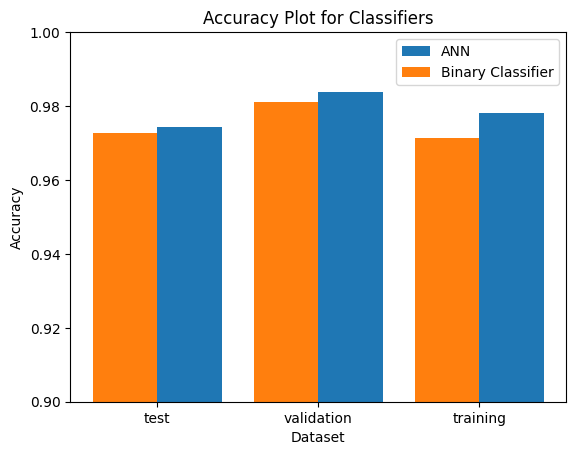

In [ ]:
X_axis =np.arange(len(plots))
plt.bar(X_axis+0.2,plotsA['acc'],0.4,label='ANN')
plt.bar(X_axis-0.2,plots['acc'],0.4,label='Binary Classifier')
plt.xticks(X_axis,plots['dataset'])
plt.title('Accuracy Plot for Classifiers')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0.9,1.0)
plt.legend()
plt.savefig('./graph/compare.png')

In [111]:
outputs = []
for k in tqdm.tqdm([1,2,4,8,16,32,64]):
    output = eval_siamese(X_test,y_test,k=k)
    outputs.append(output)

  0%|          | 0/7 [00:00<?, ?it/s]

In [112]:
plots = pd.DataFrame(outputs)

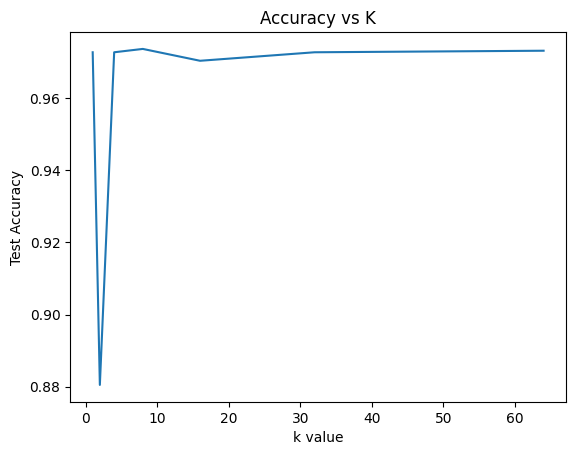

In [113]:
plt.plot(plots['k'],plots['acc'])
plt.title('Accuracy vs K')
plt.xlabel('k value')
plt.ylabel('Test Accuracy')
plt.savefig('./graph/acc_vs_k.png')